## Pembuatan model multi-variabel

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib.pyplot as plt
import scipy.special as sc
import pandas as pd
import pymc3 as pm
import arviz as az
import corner

import theano
import theano.tensor as tt
from theano.compile.ops import as_op

az.style.use("arviz-darkgrid")

### Cari jarak Bulan saat pengamatan

In [2]:
from astropy import units as u
from skyfield.api import load

In [35]:
# load timescale dan tampilkan waktu saat ini
ts = load.timescale()
# t = ts.now()

# custom waktu untuk yyyy, mm, dd, hh, mm, ss
t = ts.utc(2020, 7, 29, 17, 17, 58.7247828)

In [36]:
# Load the JPL ephemeris DE421 (covers 1900-2050) dan cari jarak Bumi-Bulan
# planets = load('de421.bsp')
planets = load('de423.bsp')
earth, moon = planets['earth'], planets['moon']

In [37]:
# posisi Bulan dari Bumi
astrometric = earth.at(t).observe(moon)
ra, dec, distance = astrometric.radec()

In [38]:
# tampilkan koordinat Bulan dan jarak Bulan dalam km
print(ra)
print(dec)
print(distance.km)

16h 15m 32.10s
-19deg 12' 50.2"
374348.0152289185


In [39]:
# Sementara dianggap konstanta
# ============================
x_data = np.linspace(-100, 100, 500)

λ_init = 7000 * u.Angstrom # satuan Å

# Jarak Bulan diambil dari perhitungan 'skyfield'
d_moon = distance.km * u.km # satuan km
λ_range = np.linspace(4000, 9000, len(x_data))

In [40]:
d_moon

<Quantity 374348.01522892 km>

In [41]:
def fresnel_func(x, λ, d, A):
    w = x*u.m * np.sqrt(2 / (λ * d))
    w = w.decompose()*1.*u.dimensionless_unscaled
    
    cc, ss = sc.fresnel(w.value)
    y = A*0.5*((cc + 0.5)**2 + (ss + 0.5)**2)
#     y_new = np.convolve(y, λ_range
    return y

In [42]:
A_true = 1000.
σ_true = 75.

y_data = fresnel_func(x_data, λ_init, d_moon, A_true)
y_data = np.random.normal(y_data, scale=σ_true)

In [43]:
y_data.shape

(500,)

Text(0, 0.5, 'Intensity')

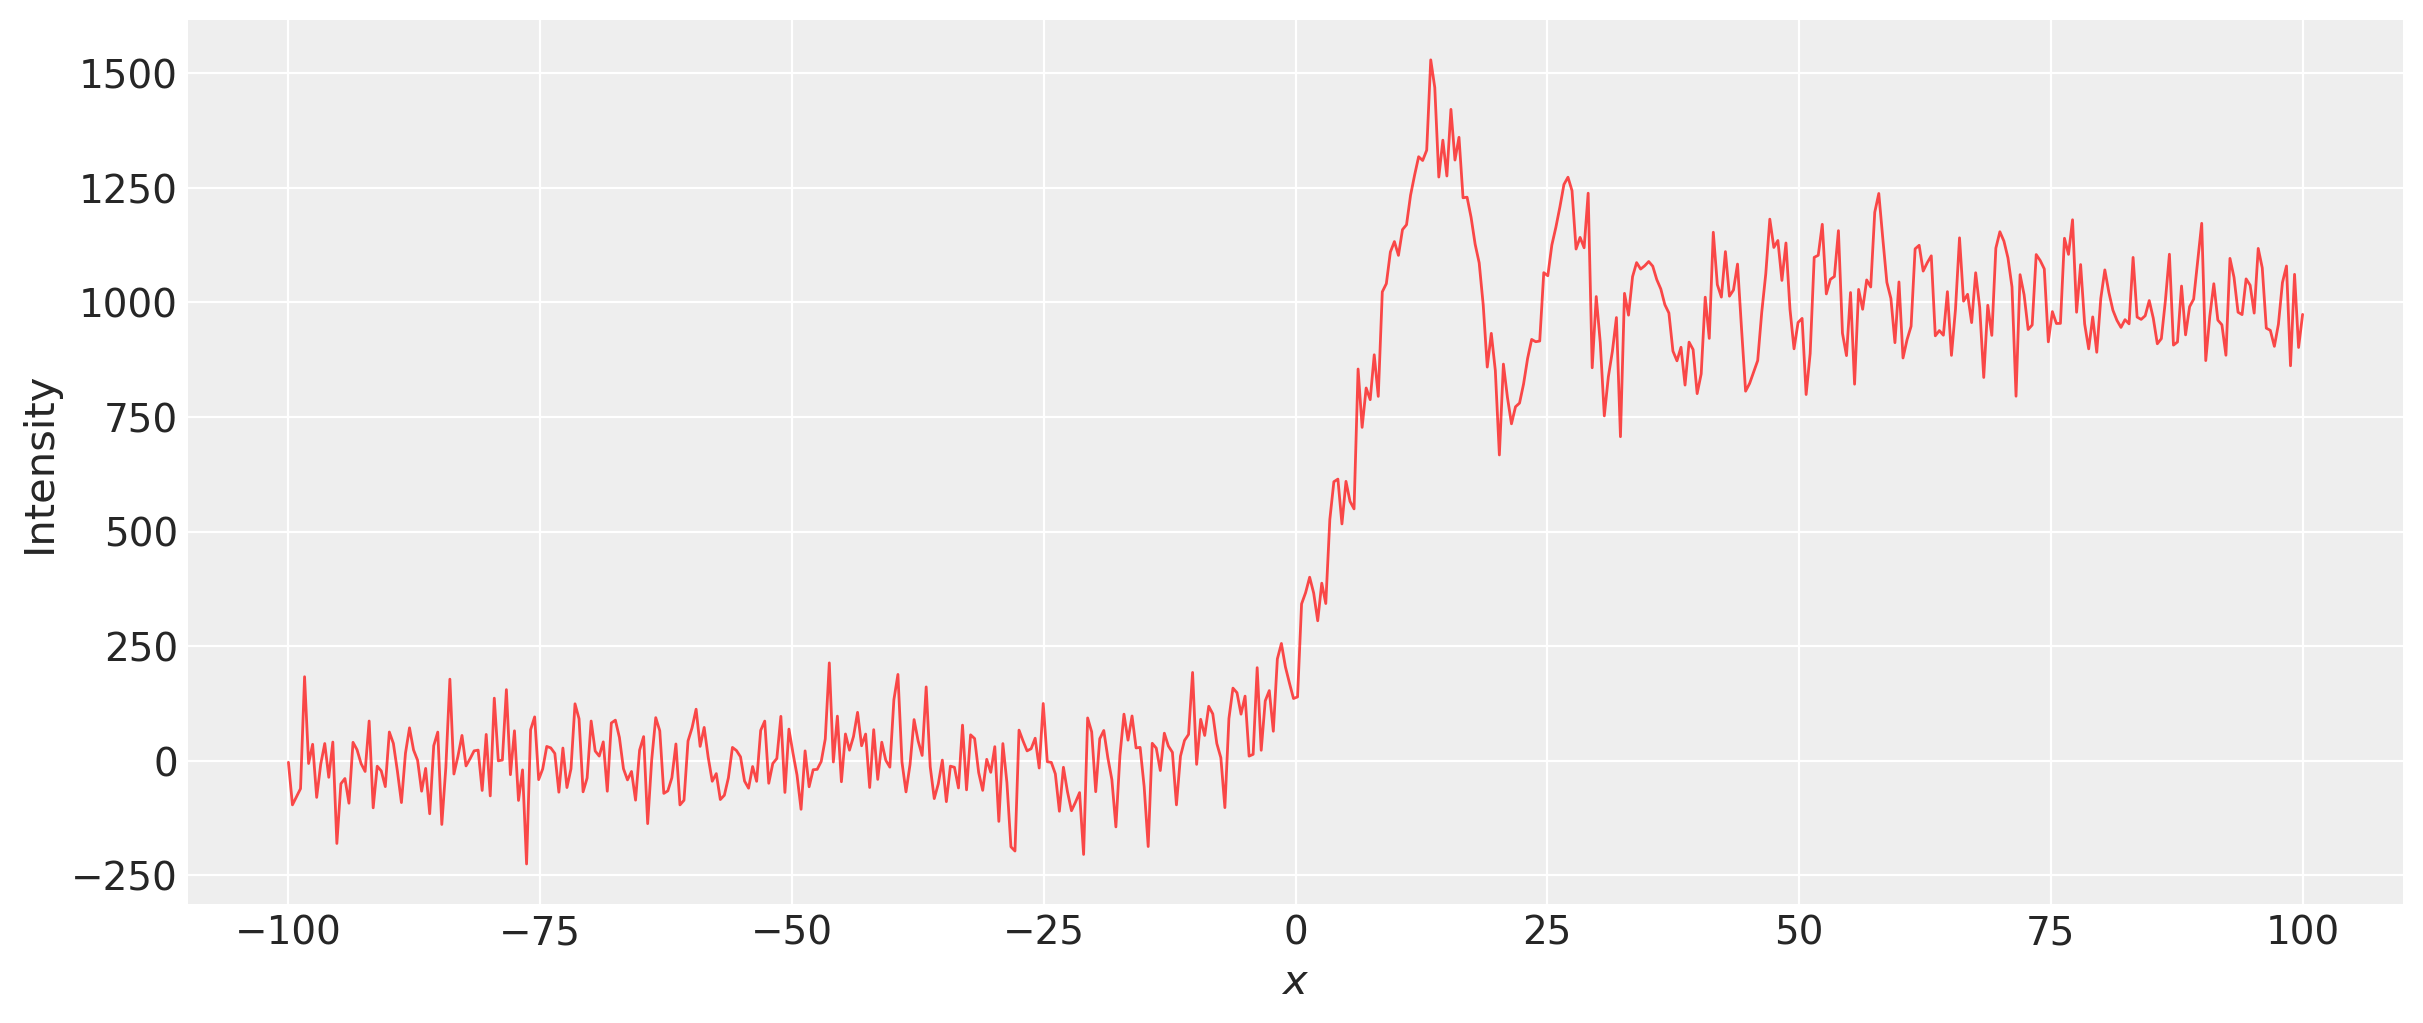

In [44]:
plt.figure(figsize = (12,5), facecolor='w')
# plt.scatter(x_data, y_data, c='r', s=5)
plt.plot(x_data, y_data, 'r-', lw=1, alpha=0.7)
plt.xlabel(r'$x$')
plt.ylabel('Intensity')

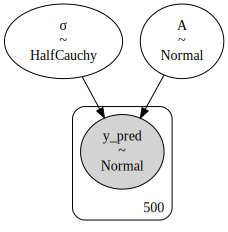

In [45]:
with pm.Model() as fresnel_model:
    A = pm.Normal('A', mu=950, sigma=1000)
    σ = pm.HalfCauchy('σ', beta=1.)
    
    μ = fresnel_func(x_data, λ_init, d_moon, A)
    y_pred = pm.Normal('y_pred', mu=μ, sd=σ, observed=y_data)
    
pm.model_to_graphviz(fresnel_model)

In [46]:
with fresnel_model:
    trace = pm.sample(2000, tune=2000, return_inferencedata=True, cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [σ, A]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


In [47]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
A,1000.575,4.561,991.716,1008.565,0.074,0.052,3835.0,3071.0,1.0
σ,72.130,2.252,68.024,76.389,0.037,0.026,3763.0,2836.0,1.0


In [48]:
chain_count =  trace.posterior.stack(sample=("chain", "draw")).σ.values.shape[0]
y_pred_g = pm.sample_posterior_predictive(trace, samples=chain_count, model=fresnel_model)

In [49]:
crit_l = np.percentile(y_pred_g['y_pred'], 2.5, axis=0)  # 2.5% persentil 
crit_u = np.percentile(y_pred_g['y_pred'], 97.5, axis=0)  # 97.5% persentil
mean_spp = np.mean(y_pred_g['y_pred'], axis=0) # Median

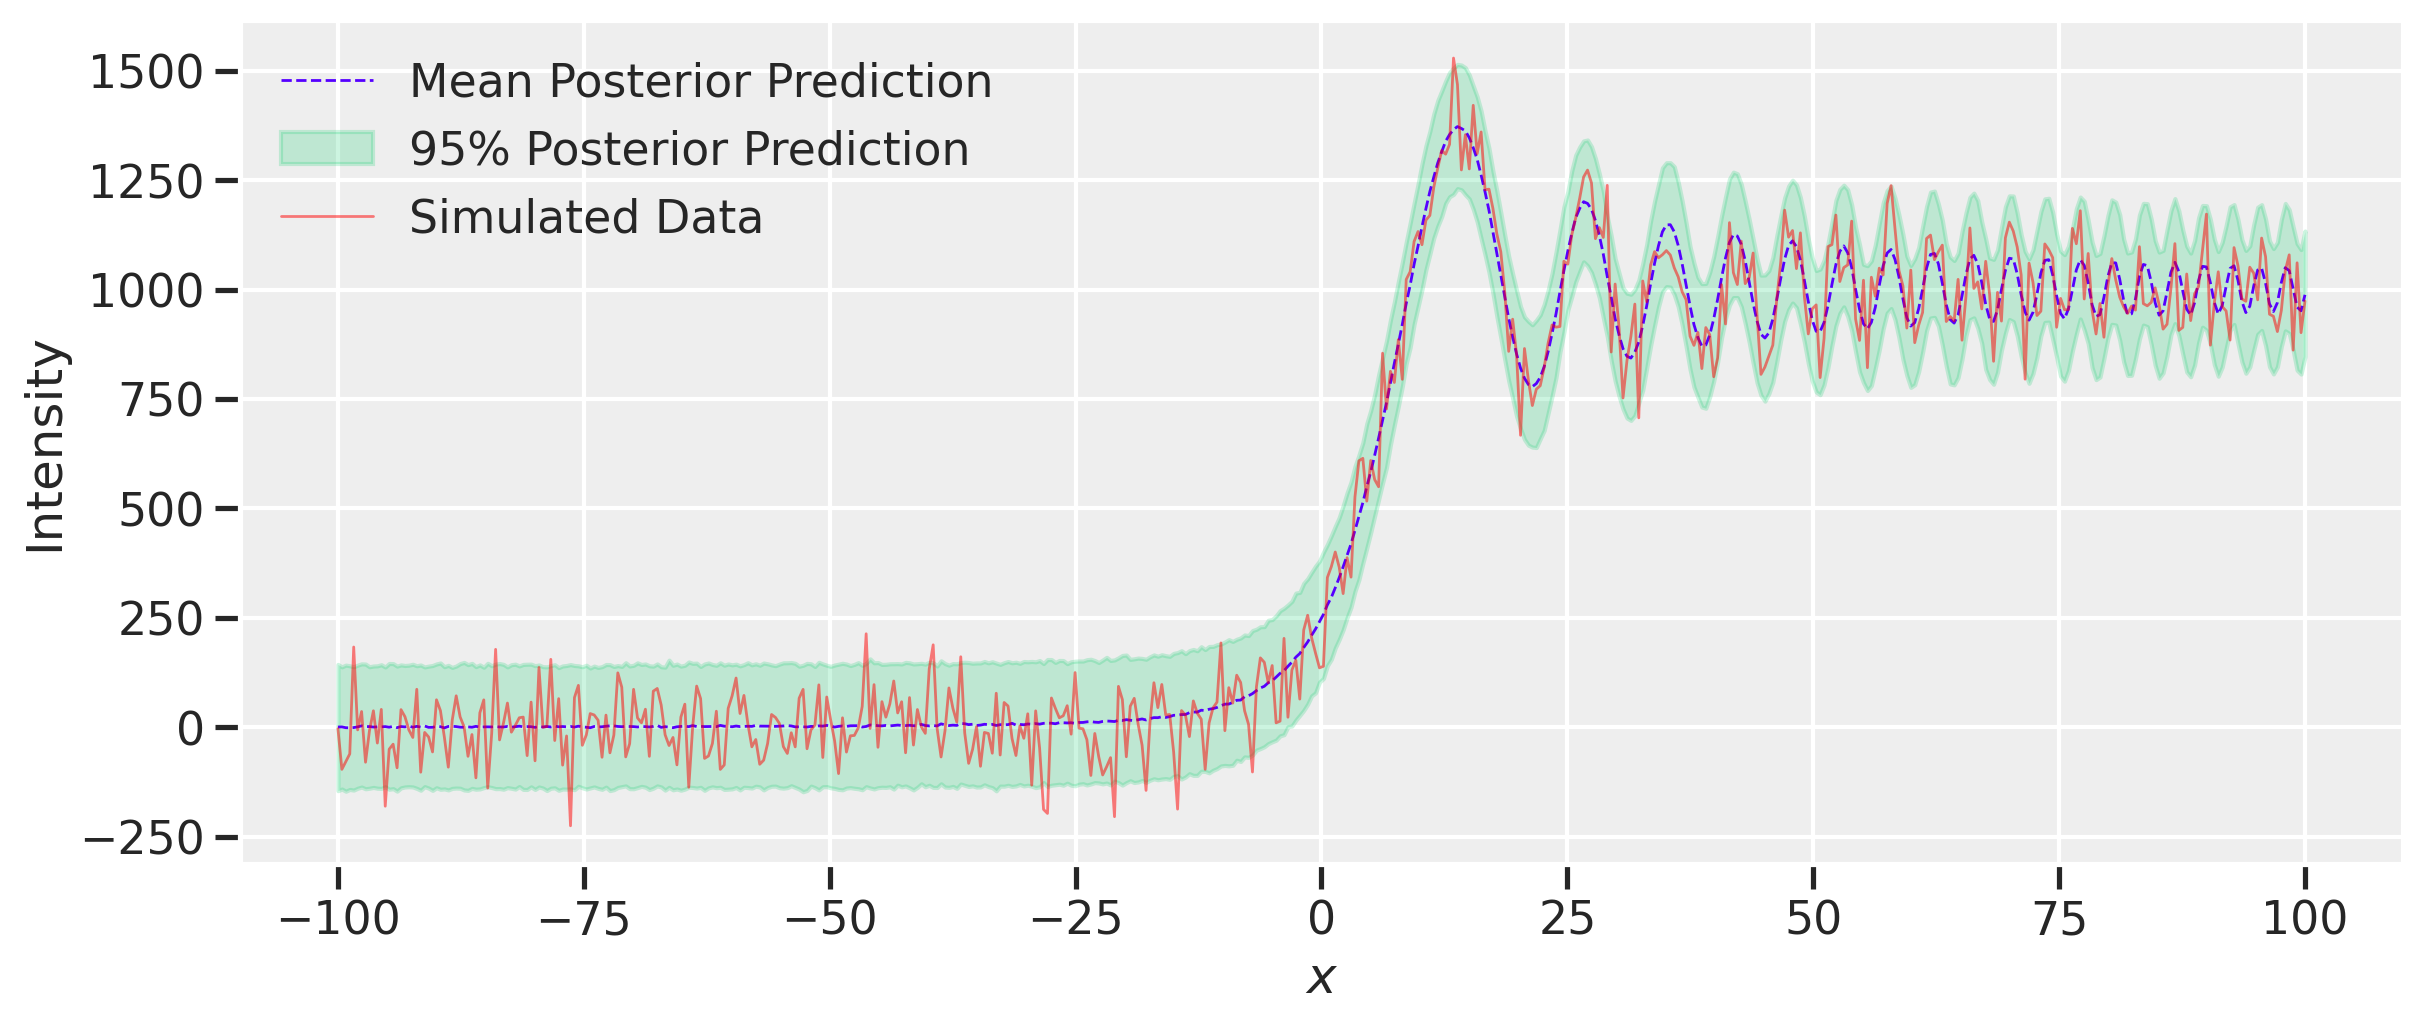

In [50]:
import seaborn as sns

with sns.plotting_context('talk', font_scale=1.):
    _, ax = plt.subplots(figsize=(12,5 ))

    plt.plot(x_data, mean_spp, linestyle='--', linewidth=1, color="#5500ff")
    plt.fill_between(x_data, crit_l, crit_u, alpha=0.2, color="#00cc66")
    # plt.scatter(x_data, y_data, c='r', marker='.', s=3)
    plt.plot(x_data, y_data, 'r-', lw=1, alpha=0.5)
    plt.xlabel(r'$x$')
    plt.ylabel('Intensity')
    plt.legend(['Mean Posterior Prediction', '95% Posterior Prediction', 'Simulated Data'])

<AxesSubplot:xlabel='A', ylabel='σ'>

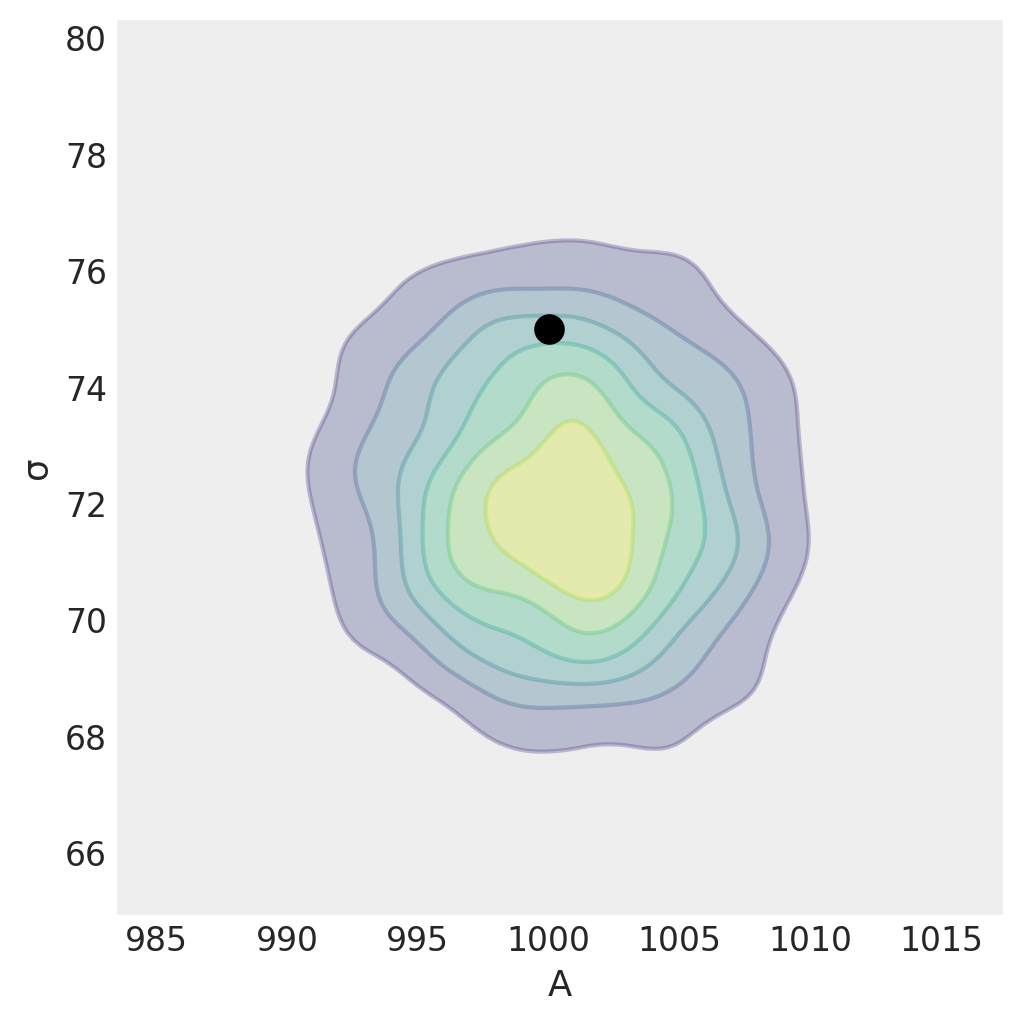

In [51]:
az.plot_pair(
    trace,
    var_names=['A', 'σ'],
    kind='kde',
    kde_kwargs={"contourf_kwargs":{"alpha": 0.3}, 
                "contour_kwargs": {"colors": None, "cmap": plt.cm.viridis, "alpha": 0.3}
               },
    figsize=(5,5),
    reference_values={"A":1000., "σ": 75},
    reference_values_kwargs={"marker": 'o', "ms": 10, "color": "k"},
)

In [52]:
y_data.shape

(500,)

## Model dengan memperhitungkan efek polikromatik

In [53]:
import astropy.units as u

In [54]:
# buat x-axis data. σ_true, dan A_true lagi supaya tidak bercampur
x_data2 = np.linspace(-100, 100, 500)
A_true2 = 1000.
σ_true2 = 2e3

# Rentang λ yang diperhitungkan dari 5500 s.d. 9000 Å, dengan selisih 100 Å dan bobot dianggap sama
bandwidth = np.arange(550, 900, 10) * u.nm

# Jarak Bulan dari teleskop, ambil nilai d_moon sebelumnya (sesuai waktu pengamatan)
d_moon2 = d_moon


In [58]:
# Model polikromatik
def fresnel_polikromatik(x, d, A):
    y0 = np.zeros(len(x))
    for i in range (len(bandwidth)):
        w = x * u.m * np.sqrt(2 / (bandwidth[i] * d))
        fre_num = w.decompose() * 1. * u.dimensionless_unscaled
        cc, ss = sc.fresnel(fre_num.value)
        # y = 0.5*((cc + 0.5)**2 + (ss + 0.5)**2)
        y = A * 0.5 * ((cc + 0.5)**2 + (ss + 0.5)**2)
        y0 += y
    return y0

In [59]:
y_data2 = fresnel_polikromatik(x_data2, d_moon2, A_true2)
y_data2 = np.random.normal(y0, scale=σ_true2)

Text(0, 0.5, 'Intensity')

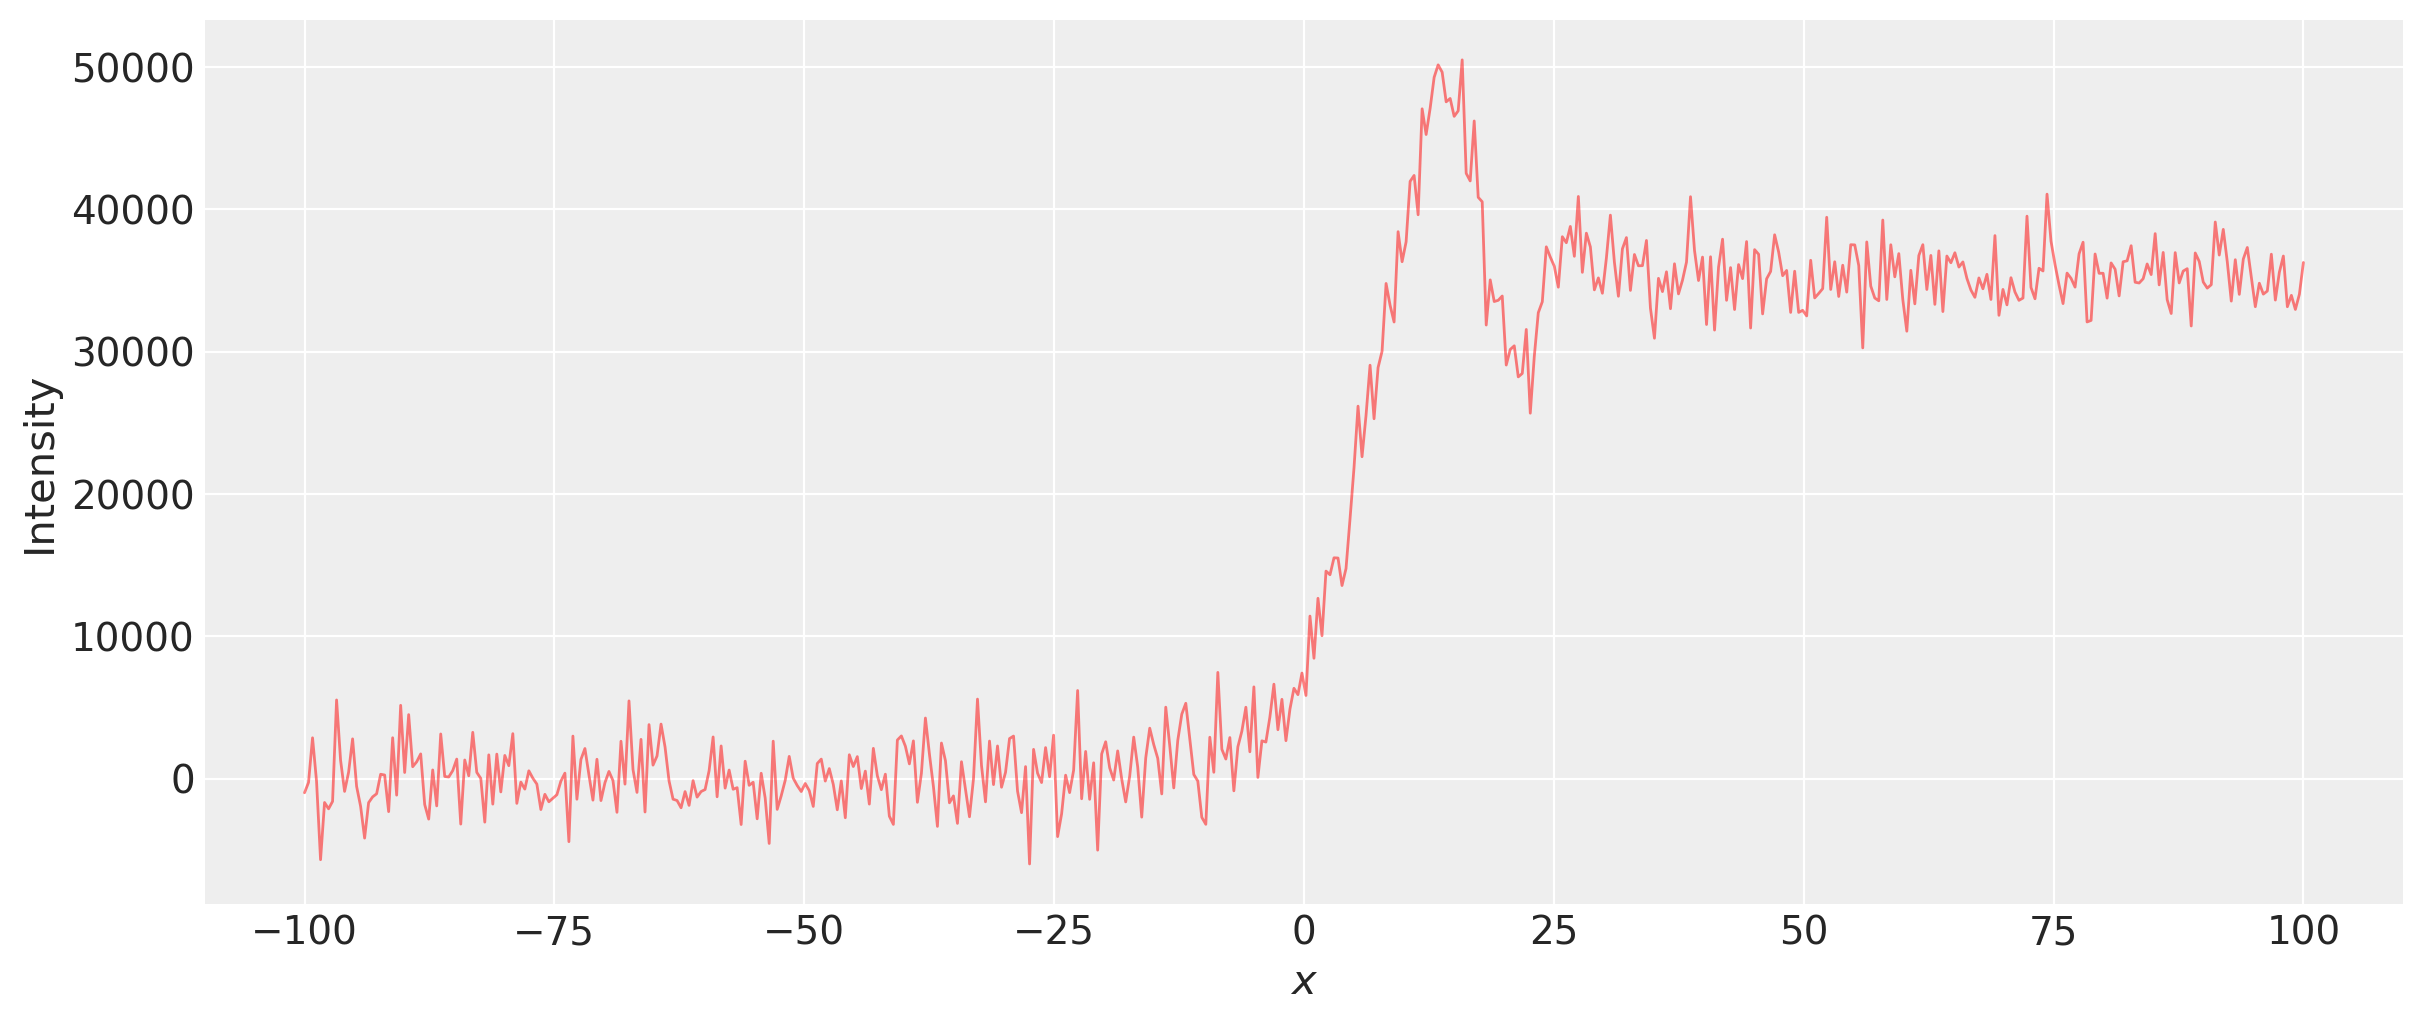

In [60]:
plt.figure(figsize = (12,5), facecolor='w')
# plt.scatter(x_data2, y_data2, c='r', s=5)
plt.plot(x_data2, y_data2, 'r-', lw=1, alpha=0.5)
plt.xlabel(r'$x$')
plt.ylabel('Intensity')

In [ ]:
import statistics
from scipy.stats import norm

In [ ]:
def kernel(x):
    mean = statistics.mean(x)
    sd = statistics.mean(x)
    y = norm.pdf(x, mean, sd)
    return y

In [ ]:
kernel_1D = kernel(bandwidth)

In [ ]:
kernel_1D.shape

In [ ]:
y_baru = np.convolve(y_data, kernel_1D, mode='same')

In [ ]:
plt.figure(figsize = (12,5), facecolor='w')
plt.scatter(x_data, y_baru, c='r', s=5)
plt.xlabel(r'$x$')
plt.ylabel('Intensity')